In [1]:
from PIL import Image, ImageFilter
import numpy as np
import pandas as pd
import cv2

from skimage.measure import label, regionprops_table
from pathlib import Path

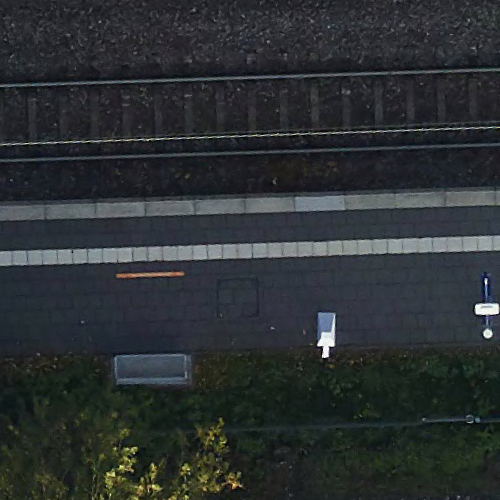

In [2]:
image = Image.open("working_example.png")
# image = Image.open("not_working_example.png")

image

In [3]:
def remove_noise(mask, radius=2, threshold=127):
    return mask.filter(ImageFilter.GaussianBlur(radius=radius)).point(lambda p: 255 if p > threshold else 0 )

def remove_noise_2(mask):
    return Image.fromarray(cv2.morphologyEx(np.array(mask), cv2.MORPH_OPEN, np.ones((3, 3))))

def get_cropped_bboxes(image, df):
    patches = []
    for _, row in df.iterrows():
        cropped_image = image.crop((row['bbox-1'],row['bbox-0'], row['bbox-3'],row['bbox-2']))
        rotated_image = cropped_image.rotate(- row["orientation"] * 180 / np.pi, expand=True)
        w, h = rotated_image.size
        lr_rm = (w - row['axis_minor_length']) / 2
        ud_rm = (h - row['axis_major_length']) / 2
        bbox_img = rotated_image.crop((lr_rm, ud_rm, w-lr_rm, h-ud_rm))
        patches.append(bbox_img)
    return patches

def apply_hsv_filter(image, min_h, max_h, min_s, max_s, min_v, max_v):
    image_hsv = image.convert("HSV")
    arr = np.array(image_hsv)
    h, s, v = arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]
    mask_arr = np.zeros(arr.shape[:2], dtype="uint8")
    mask_arr[
        (h >= min_h) & (h <= max_h)
        & (s >= min_s) & (s <= max_s) 
        & (v >= min_v) & (v <= max_v) 
    ] = 255
    mask = Image.fromarray(mask_arr)

    return mask

def apply_white_filter(image):
    return apply_hsv_filter(image, 0, 255, 0, 127, 127, 255)

def has_blue_box(image):
    min_area = 100
    max_area = 150
    min_axis_major_length = 25
    max_axis_major_length = 35
    min_axis_minor_length = 5
    max_axis_minor_length = 15
    if np.sum(np.array(image)) == 0:
        return False, None, None

    mask = apply_hsv_filter(image, 150, 190, 130, 255, 40, 255)
    labelled_mask = label(np.array(mask) > 127)
    properties = ['area', 'bbox', 'axis_major_length', 'axis_minor_length', 'orientation', 'centroid', 'area_convex', 'filled_area']
    df = pd.DataFrame(regionprops_table(labelled_mask, properties=properties))
    filtered_df = df[
        (df["area"] + 20 < df["area_convex"])
        & (min_area < df["area"]) & (df["area"] < max_area)
        & (min_axis_minor_length < df["axis_minor_length"]) & (df["axis_minor_length"] < max_axis_minor_length)
        & (min_axis_major_length < df["axis_major_length"]) & (df["axis_major_length"] < max_axis_major_length)    
    ]
    patches = get_cropped_bboxes(image, filtered_df)
    for img_patch in get_cropped_bboxes(image, filtered_df):
        labelled_patch = label(np.array(apply_white_filter(img_patch)) > 127)
        patch_df = pd.DataFrame(regionprops_table(labelled_patch, properties=properties))
        margin_ratio = 0.3
        w, h = img_patch.size
        filtered_patch_df = patch_df[
            (patch_df["area"] > 10)
            & (h * margin_ratio < patch_df["centroid-0"])
            & (patch_df["centroid-0"] < h * (1- margin_ratio))
            & (w * margin_ratio < patch_df["centroid-1"])
            & (patch_df["centroid-1"] < w * (1- margin_ratio))
        ]
        if len(filtered_patch_df) > 0:
            return True, mask, filtered_df, patches

    return False, mask, filtered_df, []

In [4]:
flag, mask, filtered_df, patches = has_blue_box(image)
flag

True

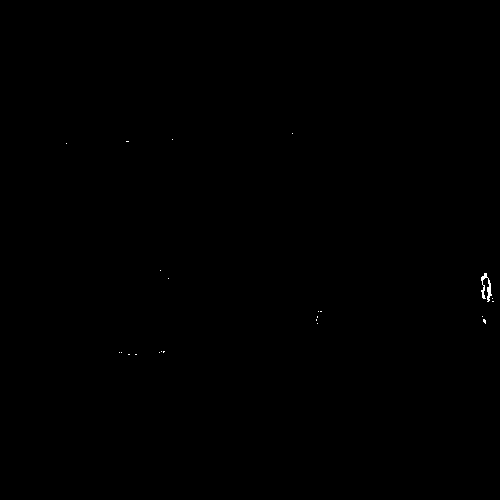

In [5]:
mask

In [6]:
filtered_df

,area,bbox-0,bbox-1,bbox-2,bbox-3,axis_major_length,axis_minor_length,orientation,centroid-0,centroid-1,area_convex,filled_area
5,134.0,273,481,302,492,31.177961,11.457236,0.105139,287.492537,485.910448,248.0,134.0


In [7]:
image.crop(tuple(filtered_df.iloc[0, [2, 1, 4, 3]]))